In [29]:
pip install xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 3.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load the data
file_path = './AAPL.csv'
data = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')

# Handle missing values by forward filling and then backfilling
data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']] = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']])

# Creating lagged features for capturing temporal dependencies
look_back = 5  # Number of lagged days you want to include
for column in ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']:
    for lag in range(1, look_back + 1):
        data[column + '_lag_' + str(lag)] = data[column].shift(lag)

# Drop any rows with NaN values which might have been introduced by shifting
data.dropna(inplace=True)

# Display the head of the processed data to verify changes
print(data.head())

# Optionally, save the processed data to a new CSV file
data.to_csv('./processed_stock_data.csv')


/var/folders/nr/0m3_2w416k95_79fx2rpjb7h0000gn/T/ipykernel_12322/2330506887.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
/var/folders/nr/0m3_2w416k95_79fx2rpjb7h0000gn/T/ipykernel_12322/2330506887.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


                Open      High       Low     Close  Adj Close    Volume  \
Date                                                                      
1980-12-19  0.000386  0.000386  0.000391  0.000389   0.000301  0.006553   
1980-12-22  0.000417  0.000417  0.000422  0.000420   0.000325  0.005034   
1980-12-23  0.000445  0.000445  0.000451  0.000448   0.000347  0.006326   
1980-12-24  0.000482  0.000481  0.000487  0.000485   0.000375  0.006468   
1980-12-26  0.000550  0.000548  0.000555  0.000552   0.000427  0.007488   

            Open_lag_1  Open_lag_2  Open_lag_3  Open_lag_4  ...  \
Date                                                        ...   
1980-12-19    0.000350    0.000333    0.000321    0.000366  ...   
1980-12-22    0.000386    0.000350    0.000333    0.000321  ...   
1980-12-23    0.000417    0.000386    0.000350    0.000333  ...   
1980-12-24    0.000445    0.000417    0.000386    0.000350  ...   
1980-12-26    0.000482    0.000445    0.000417    0.000386  ...   

    

In [3]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume,Open_lag_1,Open_lag_2,Open_lag_3,Open_lag_4,...,Adj Close_lag_1,Adj Close_lag_2,Adj Close_lag_3,Adj Close_lag_4,Adj Close_lag_5,Volume_lag_1,Volume_lag_2,Volume_lag_3,Volume_lag_4,Volume_lag_5
Date,,,,,,,,,,,,,,,,,,,,,
2024-04-29,0.875486,0.881796,0.878650,0.875745,0.876870,0.009185,0.857857,0.856090,0.840986,0.834975,...,0.855639,0.858621,0.854223,0.843506,0.838148,0.006042,0.006812,0.006502,0.006675,0.006483
2024-04-30,0.875284,0.876585,0.862910,0.859740,0.860845,0.008884,0.875486,0.857857,0.856090,0.840986,...,0.876870,0.855639,0.858621,0.854223,0.843506,0.009185,0.006042,0.006812,0.006502,0.006675
2024-05-01,0.856342,0.865160,0.858391,0.854540,0.855639,0.006789,0.875284,0.875486,0.857857,0.856090,...,0.860845,0.876870,0.855639,0.858621,0.854223,0.008884,0.009185,0.006042,0.006812,0.006502
2024-05-02,0.871142,0.868718,0.867429,0.873372,0.874494,0.012695,0.856342,0.875284,0.875486,0.857857,...,0.855639,0.860845,0.876870,0.855639,0.858621,0.006789,0.008884,0.009185,0.006042,0.006812
2024-05-03,0.942668,0.936764,0.927190,0.925629,0.926815,0.021254,0.871142,0.856342,0.875284,0.875486,...,0.874494,0.855639,0.860845,0.876870,0.855639,0.012695,0.006789,0.008884,0.009185,0.006042


In [83]:
# Correcting the way to handle DataFrame slices
latest_data = data.tail(look_back).copy()  # Use .copy() to ensure you work on a copy of the slice


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the data
file_path = './AAPL.csv'
data = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')

# Load dividend data
dividend_path = './AAPL_dividend.csv'
dividends = pd.read_csv(dividend_path, parse_dates=['Date'], index_col='Date')
data = data.join(dividends, how='left')
data['Dividends'].fillna(0, inplace=True)

# Fill missing values
data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends']  # Expanded feature set
data_scaled = scaler.fit_transform(data[features])
data_scaled_df = pd.DataFrame(data_scaled, columns=features, index=data.index)

# Avoiding any infinite or NaN issues in input data
data_scaled_df.replace([np.inf, -np.inf], np.nan, inplace=True)
data_scaled_df.dropna(inplace=True)

# Preparing data for LSTM
X = np.array(data_scaled_df.drop(['Close'], axis=1))
y = np.array(data_scaled_df['Close'])
X = X.reshape((X.shape[0], 1, X.shape[1]))

# Split data into train and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build the LSTM model
model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001, clipvalue=0.5)  # Adjusted learning rate and added clipvalue
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Check for NaN values in training or validation loss
if np.isnan(history.history['loss']).any() or np.isnan(history.history['val_loss']).any():
    print("NaN values detected during training. Consider adjusting model parameters or data preprocessing steps.")

# Predict the next stock price
predicted_scaled_price = model.predict(X_test[-1].reshape(1, 1, X_test.shape[2]))
predicted_price = scaler.inverse_transform(np.concatenate((predicted_scaled_price, np.zeros((predicted_scaled_price.shape[0], len(features)-1))), axis=1))[:, 0]
print(f"Predicted next day stock price: {predicted_price[0]}")


/var/folders/nr/0m3_2w416k95_79fx2rpjb7h0000gn/T/ipykernel_12322/3349682735.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Dividends'].fillna(0, inplace=True)
/var/folders/nr/0m3_2w416k95_79fx2rpjb7h0000gn/T/ipykernel_12322/3349682735.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
/var/folders/nr/0m3_2w416k95_79fx2rpjb7h0000gn/T/ipykernel_12322/3349682735.py:22: FutureWarning: 

Epoch 1/50
274/274 [==============================] - 3s 3ms/step - loss: 2.5424e-04 - val_loss: 0.0012
Epoch 2/50
274/274 [==============================] - 0s 1ms/step - loss: 1.8195e-05 - val_loss: 3.2601e-04
Epoch 3/50
274/274 [==============================] - 0s 1ms/step - loss: 1.9322e-05 - val_loss: 4.0088e-04
Epoch 4/50
274/274 [==============================] - 0s 1ms/step - loss: 1.6087e-05 - val_loss: 8.5666e-04
Epoch 5/50
274/274 [==============================] - 0s 2ms/step - loss: 1.5588e-05 - val_loss: 0.0016
Epoch 6/50
274/274 [==============================] - 1s 2ms/step - loss: 1.5735e-05 - val_loss: 0.0032
Epoch 7/50
274/274 [==============================] - 1s 2ms/step - loss: 1.6463e-05 - val_loss: 0.0014
Epoch 8/50
274/274 [==============================] - 0s 2ms/step - loss: 1.5501e-05 - val_loss: 0.0011
Epoch 9/50
274/274 [==============================] - 0s 1ms/step - loss: 1.7110e-05 - val_loss: 0.0026
Epoch 10/50
274/274 [==============================]

In [5]:
# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Calculating RMSE

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)

# Predict the next stock pricebb
predicted_scaled_price = model.predict(X_test[-1].reshape(1, 1, X_test.shape[2]))
predicted_price = scaler.inverse_transform(np.concatenate((predicted_scaled_price, np.zeros((predicted_scaled_price.shape[0], len(features)-1))), axis=1))[:, 0]
print(f"Predicted next day stock price: {predicted_price[0]}")


69/69 [==============================] - 0s 620us/step
Mean Squared Error: 0.0003260087651441448
Mean Absolute Error: 0.0111094723274777
Root Mean Squared Error: 0.01805571281185389
1/1 [==============================] - 0s 9ms/step
Predicted next day stock price: 177.1647457086793


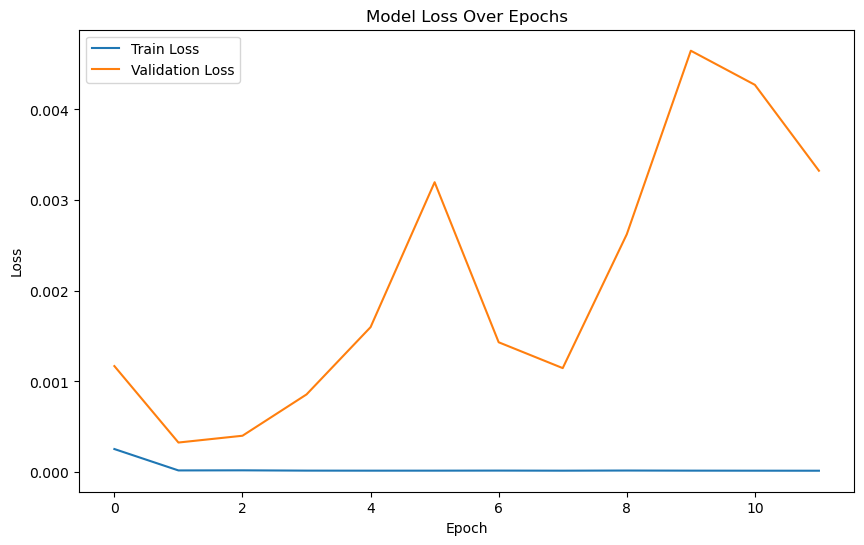

1/1 [==============================] - 0s 15ms/step
Predicted next day stock price: 177.1647457086793


In [6]:
# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Predict the next stock price
predicted_scaled_price = model.predict(X_test[-1].reshape(1, 1, X_test.shape[2]))
predicted_price = scaler.inverse_transform(np.concatenate((predicted_scaled_price, np.zeros((predicted_scaled_price.shape[0], len(features)-1))), axis=1))[:, 0]
print(f"Predicted next day stock price: {predicted_price[0]}")

In [8]:
d = pd.read_csv("../yahoo_/united-states-gdp-growth-rate.csv")
d.columns

Index(['date', ' GDP Growth', ' Annual Change'], dtype='object')

In [27]:
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.9 MB/s eta 0:00:00


In [10]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import wandb
from matplotlib import pyplot as plt
import random

# Define the folder paths for stocks, dividends, and economic data
folder_path = '../yahoo_/yahoo_sp500/'
dividend_folder_path = '../yahoo_/yahoo_sp500_div/'
gdp_file_path = '../yahoo_/united-states-gdp-growth-rate.csv'
fed_funds_file_path = '../yahoo_/FEDFUNDS.csv'
mortgage_rate_file_path = '../yahoo_/MORTGAGE30US.csv'

run = input("Do you want to start a new run or continue an existing one? ('new' or 'existing'): ")
if run.lower() == 'new':
    wandb.init(project="LSTM", entity="rk42218")
else:
    run_id = input("Enter the wandb run ID to continue: ")
    wandb.init(project="LSTM", entity="rk42218", id=run_id, resume="allow")
    
# Function to calculate RSI
def rsi_calculation(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Function to calculate MACD
def macd_calculation(data, slow=26, fast=12):
    exp1 = data.ewm(span=fast, adjust=False).mean()
    exp2 = data.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd, signal

# Load economic data and interpolate missing values
gdp_data = pd.read_csv(gdp_file_path, parse_dates=['date'], index_col='date').interpolate()
fed_funds_data = pd.read_csv(fed_funds_file_path, parse_dates=['DATE'], index_col='DATE').interpolate()
mortgage_rate_data = pd.read_csv(mortgage_rate_file_path, parse_dates=['DATE'], index_col='DATE').interpolate()

# Initialize lists to store metrics and predicted prices for all stocks
all_metrics = []
all_actual_predicted_prices = []

# Process files that have not been processed yet
all_files = [f for f in os.listdir(folder_path) if f.endswith('.csv') and f.split('.')[0] not in processed_tickers]
for filename in all_files:
    ticker_name = filename.split('.')[0]
    print(ticker_name)
    # Load the data for the stock
    stock_file_path = os.path.join(folder_path, filename)
    data = pd.read_csv(stock_file_path, parse_dates=['Date'], index_col='Date')

    # Calculate technical indicators
    data['MA50'] = data['Close'].rolling(window=50).mean()
    data['RSI'] = rsi_calculation(data['Close'])
    data['MACD'], data['Signal'] = macd_calculation(data['Close'])
    
    clean_data = data.dropna(subset=features)
    if clean_data.empty:
        print(f"Data for {ticker_name} is empty after dropping NaN values. Skipping this stock.")
        continue

    # Scaling data
    scaler = MinMaxScaler(feature_range=(0, 1))
    features = ['Open', 'High', 'Low', 'Close', 'Volume', 'MA50', 'RSI', 'MACD', 'Signal']
    data_scaled = scaler.fit_transform(data.dropna()[features])
    data_scaled_df = pd.DataFrame(data_scaled, columns=features, index=data.dropna().index)

    # Preparing data for LSTM
    X = np.array(data_scaled_df.drop(['Close'], axis=1))
    y = np.array(data_scaled_df['Close'])
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Split data into train and test sets
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    
    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_test shape:", y_test.shape)
    
    if X_train.size == 0 or X_test.size == 0:
        print(f"Not enough data to split for {ticker_name}. Skipping.")
        continue

    # Build and train the LSTM model
    model = Sequential([
        LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

    # Predict the next stock price for the entire test set
    predicted_scaled_prices = model.predict(X_test)
    predicted_prices = scaler.inverse_transform(
        np.concatenate((predicted_scaled_prices, np.zeros((predicted_scaled_prices.shape[0], len(features) - 1))),
                       axis=1))[:, 0]

    # Actual prices
    actual_prices = scaler.inverse_transform(
        np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], len(features) - 1))), axis=1))[:, 0]

    # Evaluate the model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    # Append actual and predicted prices for this stock to the list
    last_actual_price = actual_prices[-1]
    price_difference = predicted_prices[0] - last_actual_price

    print(ticker_name ,':', mse, mae, rmse, )
    print(ticker_name ,':', last_actual_price, predicted_prices[0], price_difference, )
    
    df = pd.DataFrame({
        'Ticker': [ticker_name],
        'MSE': [mse],
        'MAE': [mae],
        'RMSE': [rmse],
        'Last Actual Price': [actual_prices[-1]],
        'Predicted Price': [predicted_prices[0]]
    })
    # Log metrics to wandb
    wandb.log({"ticker": ticker_name, "mse": mse, "mae": mae, "rmse": rmse})
    
    # Plotting actual vs predicted prices
    plt.figure(figsize=(10, 6))
    plt.plot(actual_prices, label='Actual Prices')
    plt.plot(predicted_prices, label='Predicted Prices', color='red')
    plt.title(f'Comparison of Actual and Predicted Stock Prices ({ticker_name})')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()

    # Create a wandb chart object for actual vs predicted prices plot
    actual_predicted_chart = wandb.Image(plt)

    # Log the wandb chart object to wandb
    wandb.log({"Actual_vs_Predicted_Prices": actual_predicted_chart})

    # Plotting model loss over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss Over Epochs ({ticker_name})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Create a wandb chart object for model loss over epochs plot
    loss_chart = wandb.Image(plt)

    # Log the wandb chart object to wandb
    wandb.log({"Model_Loss_Over_Epochs": loss_chart})
    
    excel_file_path = 'all_stocks_data_with_economic_data.xlsx'
    sheet_name = 'Stock_Data'

    # Check if the file exists to decide how to handle the DataFrame writing
    if os.path.exists(excel_file_path):
        with pd.ExcelWriter(excel_file_path, engine='openpyxl', mode='a', if_sheet_exists='overlay') as writer:
            # Load existing data
            try:
                existing_data = pd.read_excel(excel_file_path, sheet_name=sheet_name)
                # Concatenate new data
                updated_data = pd.concat([existing_data, df], ignore_index=True)
                # Write the updated data
                updated_data.to_excel(writer, sheet_name=sheet_name, index=False)
            except ValueError:
                # If the sheet doesn't exist, just write the new data
                df.to_excel(writer, sheet_name=sheet_name, index=False)
    else:
        # If the file doesn't exist, just write the new data
        with pd.ExcelWriter(excel_file_path, engine='openpyxl', mode='w') as writer:
            df.to_excel(writer, sheet_name=sheet_name, index=False)

    print(f"Data for {ticker_name} appended successfully.")

    plt.close('all')
    
# Output results
for metrics in all_metrics:
    print(metrics)

wandb.finish()

Do you want to start a new run or continue an existing one? ('new' or 'existing'): new


BRO_20240512


KeyError: ['Dividends']

In [ ]:
8ec35a234a46a89ebbd86b828e73cde0

In [ ]:
    print(ticker_name ,':', last_actual_price, predicted_prices[0], price_difference, )


In [11]:
# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Calculating RMSE

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)

# Predict the next stock pricebb
predicted_scaled_price = model.predict(X_test[-1].reshape(1, 1, X_test.shape[2]))
predicted_price = scaler.inverse_transform(np.concatenate((predicted_scaled_price, np.zeros((predicted_scaled_price.shape[0], len(features)-1))), axis=1))[:, 0]
print(f"Predicted next day stock price: {predicted_price[0]}")

69/69 [==============================] - 0s 403us/step
Mean Squared Error: 7.276870052833386e-05
Mean Absolute Error: 0.005296996788280327
Root Mean Squared Error: 0.00853045722856248
1/1 [==============================] - 0s 7ms/step
Predicted next day stock price: 181.88175281370627


In [2]:
# Plotting actual vs predicted prices
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(actual_prices, label='Actual Prices')
plt.plot(predicted_prices, label='Predicted Prices', color='red')
plt.title('Comparison of Actual and Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

NameError: name 'actual_prices' is not defined

<Figure size 1000x600 with 0 Axes>

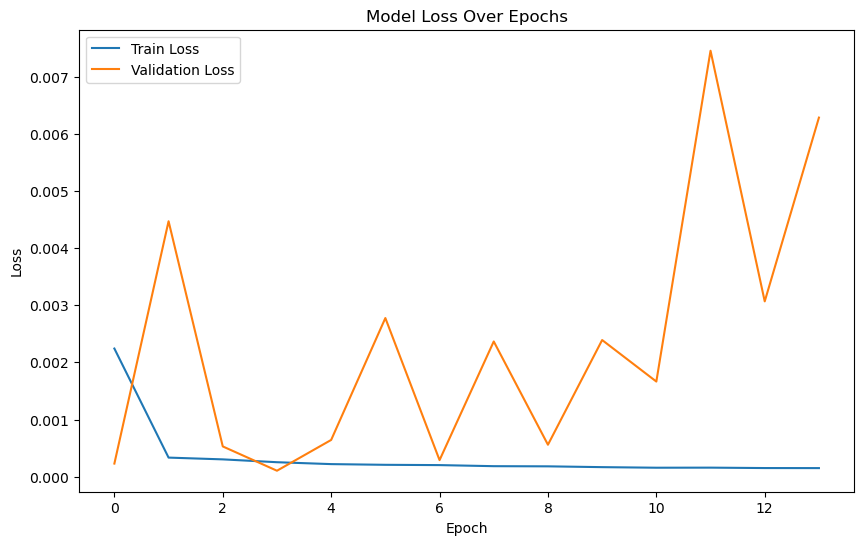

In [25]:
from matplotlib import pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
#plt.show()

In [14]:
# Predict the next stock price
predicted_scaled_price = model.predict(X_test[-1].reshape(1, 1, X_test.shape[2]))
predicted_price = scaler.inverse_transform(np.concatenate((predicted_scaled_price, np.zeros((predicted_scaled_price.shape[0], len(features)-1))), axis=1))[:, 0]
print(f"Predicted next day stock price: {predicted_price[0]}")

1/1 [==============================] - 0s 13ms/step
Predicted next day stock price: 181.88175281370627


In [10]:
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import wandb
from matplotlib import pyplot as plt
from openpyxl import load_workbook
from openpyxl import load_workbook
import pandas as pd
import numpy as np
import os
import pandas as pd
from openpyxl import load_workbook
from pandas import ExcelWriter


class StockModel:
    def __init__(self):
        self.folder_path = '../yahoo_/dunmmy/'  # Corrected path typo from 'dunmmy' to 'dummy'
        self.dividend_folder_path = '../yahoo_/yahoo_sp500_div/'
        self.gdp_file_path = '../yahoo_/united-states-gdp-growth-rate.csv'
        self.fed_funds_file_path = '../yahoo_/FEDFUNDS.csv'
        self.mortgage_rate_file_path = '../yahoo_/MORTGAGE30US.csv'
        self.init_wandb()
        self.excel_file_path = './all_stocks_data_with_economic_data.xlsx'
        self.results = self.load_existing_results()

    def init_wandb(self):
        run = input("Do you want to start a new run or continue an existing one? ('new' or 'existing'): ")
        if run.lower() == 'new':
            wandb.init(project="LSTM", entity="rk42218")
        else:
            run_id = input("Enter the wandb run ID to continue: ")
            wandb.init(project="LSTM", entity="rk42218", id=run_id, resume="allow")

    def load_economic_data(self):
        self.gdp_data = pd.read_csv(self.gdp_file_path, parse_dates=['date'], index_col='date').interpolate()
        self.fed_funds_data = pd.read_csv(self.fed_funds_file_path, parse_dates=['DATE'], index_col='DATE').interpolate()
        self.mortgage_rate_data = pd.read_csv(self.mortgage_rate_file_path, parse_dates=['DATE'], index_col='DATE').interpolate()

    @staticmethod
    def calculate_rsi(data, window=14):
        delta = data.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))

    @staticmethod
    def calculate_macd(data, slow=26, fast=12):
        exp1 = data.ewm(span=fast, adjust=False).mean()
        exp2 = data.ewm(span=slow, adjust=False).mean()
        macd = exp1 - exp2
        signal = macd.ewm(span=9, adjust=False).mean()
        return macd, signal

    def process_stocks(self):
        all_files = [f for f in os.listdir(self.folder_path) if f.endswith('.csv')]
        for filename in all_files:
            self.process_single_stock(filename)
                                                                 
    def scale_data(self, data, features):
        """Scales given features in the data."""
        scaler = MinMaxScaler(feature_range=(0, 1))
        # Ensure data for features does not contain infinity or NaN values
        data_clean = data[features].replace([np.inf, -np.inf], np.nan)
        data_clean = data_clean.dropna()  # Dropping rows with NaN values
        data_scaled = scaler.fit_transform(data_clean)
        return data_scaled, scaler  # Return both the scaled data and the scaler


    def process_single_stock(self, filename):
        ticker_name = filename.split('.')[0]
        data = pd.read_csv(os.path.join(self.folder_path, filename), parse_dates=['Date'], index_col='Date')
        print("Columns available:", data.columns)  # Check what columns are available
        # Ensure 'Close' is among the columns, otherwise adjust the column name based on what's printed
        if 'Close' not in data.columns:
            raise KeyError("Column 'Close' is missing from the data.")
        current_date = data.index.max().strftime('%Y-%m-%d')  # Using the latest date from data

        data['RSI'] = self.calculate_rsi(data['Close'])
        data['MACD'], data['Signal'] = self.calculate_macd(data['Close'])
        self.process_and_train_model(data, ticker_name, current_date)

    def process_and_train_model(self, data, ticker_name, current_date):
        features = ['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD']  # Updated to include RSI and MACD
        data_scaled, scaler = self.scale_data(data, features)  # Receive scaled data and scaler
        # Reshape data to include all features for multivariate LSTM model
        X = data_scaled[:, :-1].reshape(-1, len(features) - 1, 1)  
        y = data_scaled[:, 3]  # Assuming 'Close' is indexed at position 3

        split = int(0.8 * len(X))
        X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

        model = self.build_hybrid_model(X_train.shape[1])
        self.train_model(model, X_train, y_train, X_test, y_test)
        self.evaluate_and_log(model, X_test, y_test, scaler, ticker_name, data['Close'].iloc[-1], current_date)  # Pass scaler along

    def build_hybrid_model(self, input_dim):
        model = Sequential([
            LSTM(50, input_shape=(input_dim, 1), return_sequences=True),  # Univariate LSTM layer
            Dropout(0.2),
            LSTM(100, return_sequences=True),  # Additional LSTM layer for multivariate context
            Dropout(0.2),
            LSTM(50),  # Additional LSTM layer
            Dropout(0.2),
            Dense(1)
        ])
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
        return model

    def train_model(self, model, X_train, y_train, X_test, y_test):
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

    def evaluate_and_log(self, model, X_test, y_test, scaler, ticker_name, last_actual_price, current_date):
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mse)

        if hasattr(scaler, 'scale_'):  # Check if scaler is fitted
            try:
                full_pred = np.zeros((1, len(scaler.scale_)))  # Zero padding for features
                full_pred[:, 3] = y_pred[-1]  # Assuming 'Close' is the 4th feature
                predicted_price = scaler.inverse_transform(full_pred)[0, 3]
            except Exception as e:
                print("An error occurred during prediction transformation:", e)
                predicted_price = None
        else:
            print("Scaler has not been fitted. Cannot inverse transform predictions.")
            predicted_price = None

        if predicted_price is not None:
            self.save_to_excel(ticker_name, mse, mae, rmse, last_actual_price, predicted_price, current_date)
        else:
            print(f"Unable to save data for {ticker_name} due to missing prediction.")

    def load_existing_results(self):
        # Load existing data if the file exists, otherwise return an empty DataFrame
        if os.path.exists(self.excel_file_path):
            return pd.read_excel(self.excel_file_path)
        else:
            return pd.DataFrame(columns=['Ticker', 'Date', 'MSE', 'MAE', 'RMSE', 'Last Actual Price', 'Predicted Price'])

    def check_already_processed(self, ticker_name, current_date):
        # Check if the ticker has already been processed for the given date
        if not self.results.empty:
            processed_dates = self.results[(self.results['Ticker'] == ticker_name) & (self.results['Date'] == current_date)]
            if not processed_dates.empty:
                print(f"{ticker_name} has already been processed for {current_date}. Skipping...")
                return True
        return False

    def save_to_excel(self, ticker_name, mse, mae, rmse, last_actual_price, predicted_price, current_date):
        # Prepare the new data as a DataFrame to be appended
        new_data = pd.DataFrame({
            'Ticker': [ticker_name],
            'Date': [current_date],
            'MSE': [mse],
            'MAE': [mae],
            'RMSE': [rmse],
            'Last Actual Price': [last_actual_price],
            'Predicted Price': [predicted_price]
        })

        # Check if the Excel file exists to decide how to handle the DataFrame writing
        if os.path.exists(self.excel_file_path):
            with pd.ExcelWriter(self.excel_file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
                # Load existing data if 'Results' sheet exists
                if 'Results' in writer.book.sheetnames:
                    existing_data = pd.read_excel(self.excel_file_path, sheet_name='Results')
                    updated_data = pd.concat([existing_data, new_data], ignore_index=True)
                else:
                    updated_data = new_data

                # Write the updated data
                updated_data.to_excel(writer, sheet_name='Results', index=False)
        else:
            # If the file doesn't exist, just write the new data
            with pd.ExcelWriter(self.excel_file_path, engine='openpyxl', mode='w') as writer:
                new_data.to_excel(writer, sheet_name='Results', index=False)

        print(f"All data for {ticker_name} saved successfully to Excel.")


        
    def finish(self):
        wandb.finish()

if __name__ == "__main__":
    stock_model = StockModel()
    stock_model.load_economic_data()
    stock_model.process_stocks()
    stock_model.finish()

Do you want to start a new run or continue an existing one? ('new' or 'existing'): new


Columns available: Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


Epoch 1/50
203/203 [==============================] - 5s 11ms/step - loss: 2.4216e-04 - val_loss: 7.0377e-04
Epoch 2/50
203/203 [==============================] - 2s 8ms/step - loss: 3.5445e-05 - val_loss: 0.0033
Epoch 3/50
203/203 [==============================] - 2s 9ms/step - loss: 2.3343e-05 - val_loss: 0.0033
Epoch 4/50
203/203 [==============================] - 2s 8ms/step - loss: 2.4562e-05 - val_loss: 0.0030
Epoch 5/50
203/203 [==============================] - 2s 8ms/step - loss: 1.8588e-05 - val_loss: 0.0022
Epoch 6/50
203/203 [==============================] - 2s 8ms/step - loss: 1.7426e-05 - val_loss: 0.0011
Epoch 7/50
203/203 [==============================] - 2s 8ms/step - loss: 1.9455e-05 - val_loss: 0.0028
Epoch 8/50
203/203 [==============================] - 2s 8ms/step - loss: 1.8977e-05 - val_loss: 0.0032
Epoch 9/50
203/203 [==============================] - 2s 8ms/step - loss: 1.6376e-05 - val_loss: 0.0011
Epoch 10/50
203/203 [==============================] - 2s 8

Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 0.3778 - val_loss: 0.4333
Epoch 2/50
1/1 [==============================] - 0s 21ms/step - loss: 0.3473 - val_loss: 0.4027
Epoch 3/50
1/1 [==============================] - 0s 20ms/step - loss: 0.3168 - val_loss: 0.3716
Epoch 4/50
1/1 [==============================] - 0s 20ms/step - loss: 0.2990 - val_loss: 0.3389
Epoch 5/50
1/1 [==============================] - 0s 20ms/step - loss: 0.2687 - val_loss: 0.3036
Epoch 6/50
1/1 [==============================] - 0s 20ms/step - loss: 0.2476 - val_loss: 0.2659
Epoch 7/50
1/1 [==============================] - 0s 21ms/step - loss: 0.2227 - val_loss: 0.2254
Epoch 8/50
1/1 [==============================] - 0s 21ms/step - loss: 0.1687 - val_loss: 0.1822
Epoch 9/50
1/1 [==============================] - 0s 21ms/step - loss: 0.1517 - val_loss: 0.1373
Epoch 10/50
1/1 [==============================] - 0s 21ms/step - loss: 0.1384 - val_loss: 0.0928
Epoch 11/50
1/1 [==============

Epoch 1/50
68/68 [==============================] - 4s 16ms/step - loss: 0.0127 - val_loss: 0.0013
Epoch 2/50
68/68 [==============================] - 1s 8ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 3/50
68/68 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 8.6374e-05
Epoch 4/50
68/68 [==============================] - 1s 9ms/step - loss: 8.2191e-04 - val_loss: 1.2653e-04
Epoch 5/50
68/68 [==============================] - 1s 9ms/step - loss: 8.4525e-04 - val_loss: 2.5084e-04
Epoch 6/50
68/68 [==============================] - 1s 9ms/step - loss: 8.4970e-04 - val_loss: 0.0011
Epoch 7/50
68/68 [==============================] - 1s 9ms/step - loss: 7.0735e-04 - val_loss: 3.0599e-04
Epoch 8/50
68/68 [==============================] - 1s 9ms/step - loss: 7.4481e-04 - val_loss: 5.8207e-04
Epoch 9/50
68/68 [==============================] - 1s 8ms/step - loss: 8.0442e-04 - val_loss: 3.6927e-04
Epoch 10/50
68/68 [==============================] - 1s 8ms/step - lo

Epoch 1/50
140/140 [==============================] - 4s 11ms/step - loss: 0.0093 - val_loss: 1.1325e-04
Epoch 2/50
140/140 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 2.0757e-04
Epoch 3/50
140/140 [==============================] - 1s 7ms/step - loss: 0.0011 - val_loss: 1.1422e-04
Epoch 4/50
140/140 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 4.3471e-04
Epoch 5/50
140/140 [==============================] - 1s 7ms/step - loss: 9.0507e-04 - val_loss: 2.5126e-04
Epoch 6/50
140/140 [==============================] - 1s 7ms/step - loss: 9.2886e-04 - val_loss: 0.0011
Epoch 7/50
140/140 [==============================] - 1s 7ms/step - loss: 8.3736e-04 - val_loss: 1.9070e-04
Epoch 8/50
140/140 [==============================] - 1s 7ms/step - loss: 8.3189e-04 - val_loss: 5.3163e-04
Epoch 9/50
140/140 [==============================] - 1s 7ms/step - loss: 7.2031e-04 - val_loss: 0.0029
Epoch 10/50
140/140 [==============================

In [2]:
import pandas as pd
print(pd.__version__)

2.2.0
